# Carotte 4.0 : Traitement d'images Hyperspectrales
Ce notebook Jupyter présentera les différentes expérimentations qui ont mené à la détermination de notre Pipeline de traitement d'images hyperspectrales.

In [43]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import sklearn
%matplotlib inline

# Données
Les deux images que nous possédons pour créer notre pipeline ont été acquises par le capteur AVIRIS.

## Afficher des images hyperspectrales en rgb

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.

Wikipedia donne :
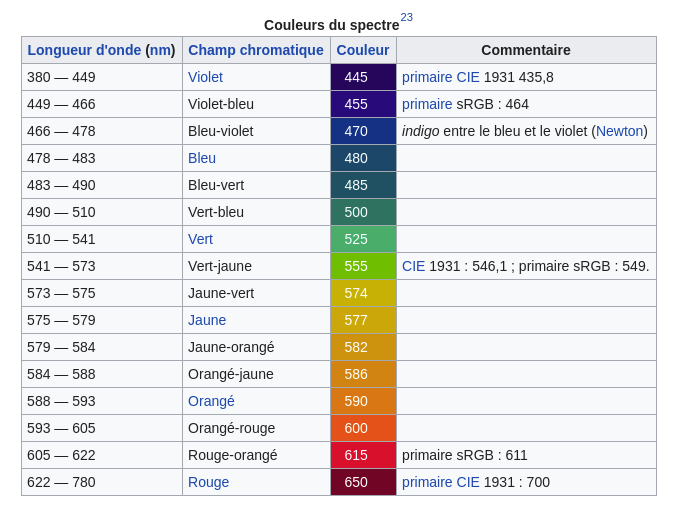

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [44]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
def rgb_bands(arr):
    r = find_index_wavelength(611)
    g = find_index_wavelength(549)
    b = find_index_wavelength(464)
    return [r, g, b]
def pimpImageInRgb(image, rgb_bands):
    img_rgb = image.copy()[:,:,rgb_bands]
    
    rgb_min, rgb_max = np.percentile(img_rgb, (1, 99), axis=(0,1))

    new_image = img_rgb.copy()
    for i in range(rgb_min.size):
        new_image[:,:,i] = (img_rgb[:,:,i] - rgb_min[i]) / (rgb_max[i] - rgb_min[i])
    
    new_image[new_image < 0] = 0
    new_image[new_image > 1] = 1
    return new_image

## Indiana Pines
C'est la première image que nous possédons. Elle à une résolution de 145x145 pixels, ce qui donne une résolution au sol de 20 m/pixel.
L'image de vérité terrain contient 15 classes différentes, avec la classe 0 appartenant à la catégorie "Inconnu".

In [45]:
# import de l'image indiana pines
arr_indiana = np.load("./data/indianapines.npy")
arr_indiana_gt = np.load("./data/indianapines_gt.npy")

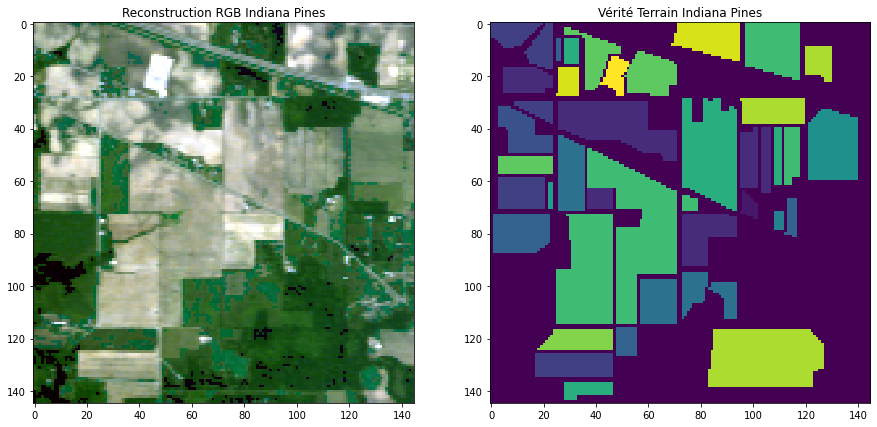

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_indiana_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_indiana), rgb_bands(arr_indiana)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [53]:
indiana_dict = {
    "unknown" : 10776,
    "alfalfa" : 46,
    "corn-notill": 1428,
    "corn-mintill": 830,
    "corn": 237,
    "grass-pasture": 483,
    "grass-trees": 730,
    "grass-pasture-mowed": 28,
    "hay-windrowed": 478,
    "oats": 20,
    "soybean-notill": 972,
    "soybean-mintill": 2455,
    "soybean-clean": 593,
    "wheat": 205,
    "woods": 1265,
    "buildings-grass-trees-drives": 386,
    "stone-steel-towers": 93
}

On remarque le manque d'information pour certaines classes, notamment "oats" et "grass-pasture-mowed". Cela rendra la classification difficile pour ces classes en particulier.

## Salinas
Cette image possède des classes différentes de l'image Indiana Pines. Elle à aussi une résolution supérieure de 512x217 pixels.
Elle devrait ainsi être plus simple à traiter.

In [54]:
# import de la vérité terrain
arr_salinas = np.load("./data/salinas.npy")
arr_salinas_gt = np.load("./data/salinas_gt.npy")

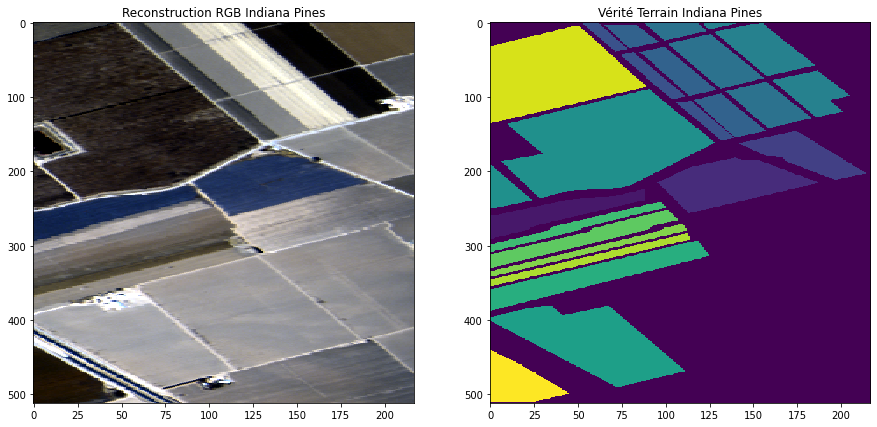

In [55]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_salinas_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_salinas), rgb_bands(arr_salinas)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [58]:
salinas_dict = {
    "unknown" : 56975,
    "brocoli_green_weeds_1" : 2009,
    "brocoli_green_weeds_2" : 3726,
    "fallow" : 1976,
    "fallow_rough_plow" : 1394,
    "fallow_smooth" : 2678,
    "stubble" : 3959,
    "celery" : 3579,
    "grapes_untrained" : 11271,
    "soil_vinyard_develop" : 6203,
    "corn_senesced_green_weeds" : 3278,
    "lettuce_romaine_4wk" : 1068,
    "lettuce_romaine_5wk" : 1927,
    "lettuce_romaine_6wk" : 916,
    "lettuce_romaine_7wk" : 1070,
    "vinyard_untrained" : 7268,
    "vinyard_vertical_trellis" : 1807
}

**Essayer de retirer totalement la classe unknown du dataset de train ?**

# Réduction de dimension
Les images hyperspectrales possédant un nombre très important de bandes pour chaque pixel, elle pourront fortement bénificier d'une réduction, permettant de traiter ces images plus rapidement, et de se focaliser sur les caractéristiques essentielles.

## Analyse en composantes principales
La technique d'analyse en composantes principales (ou PCA) permet d'effectuer une réduction de dimension, en ne gardant que les premières composantes.
Appliquons cette méthode à nos images, et observons la perte de données associée.

In [75]:
def show_info_pca(arr):
    row, col, dim = arr.shape
    # The array is reshaped to be flat
    arr_flat = arr.reshape((-1, dim))
    
    import sklearn.decomposition
    pca_arr = sklearn.decomposition.PCA()
    pca_arr.fit(arr_flat)
    
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Explained variance per PC')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.subplot(122)
    plt.title('Explained variance per PC (in log scale)')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.yscale('log')
    plt.show()
    
    nb_comp = 10
    
    arr_projected = pca_arr.transform(arr_flat)
    arr_projected_small = arr_projected[:,:nb_comp].reshape((row,col,10))
    
    plt.figure(figsize=(30,15))
    for i in range(nb_comp):
        plt.subplot(2,5,i+1)
        plt.title('PC %d'%(i+1),fontsize=18)
        plt.imshow(arr_projected_small[:,:,i],cmap='gray')
    plt.show()
    
    arr_projected_full = arr_projected.copy()
    arr_projected_full[:,10:] = 0
    arr_proj_back = pca_arr.inverse_transform(arr_projected_full).reshape((row,col,dim))
    
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(pimpImageInRgb(normalize(arr), rgb_bands(arr)))
    plt.subplot(122)
    plt.imshow(pimpImageInRgb(normalize(arr_proj_back), rgb_bands(arr_proj_back)))
    plt.show()

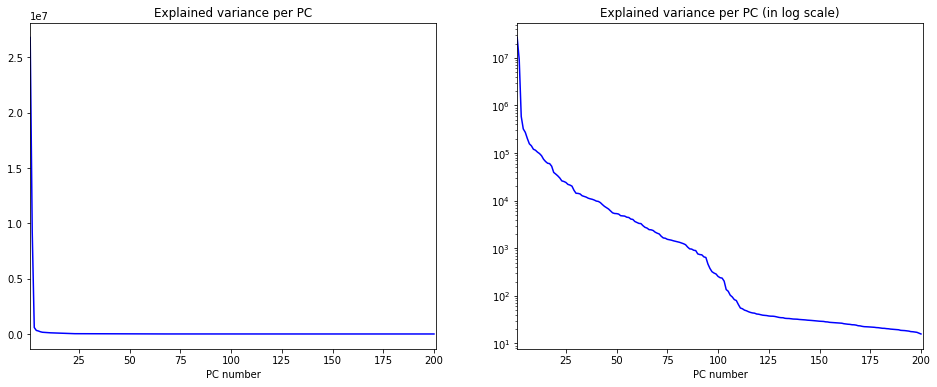

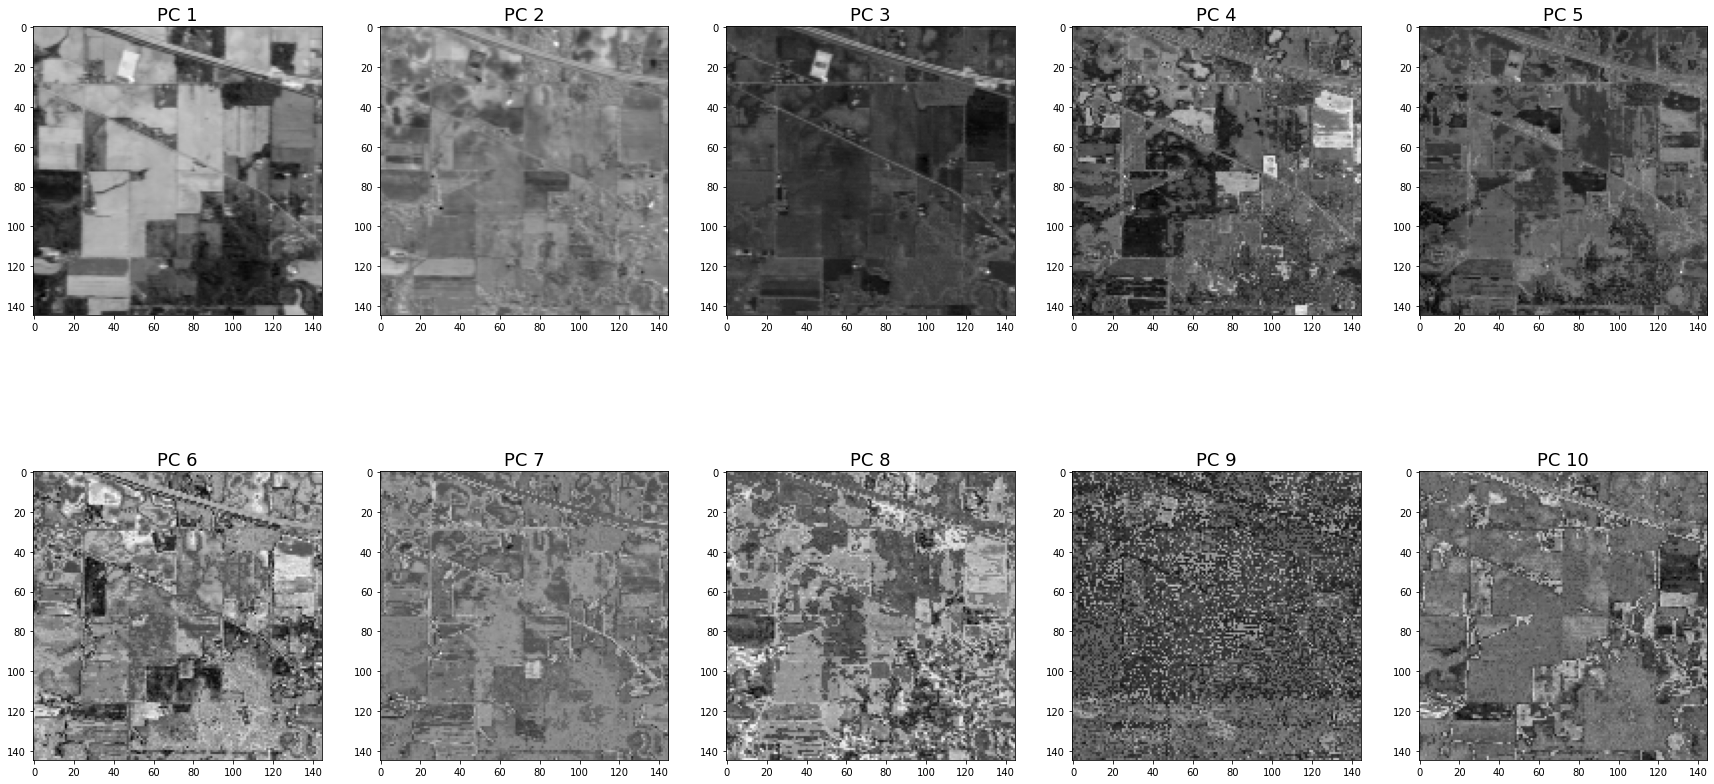

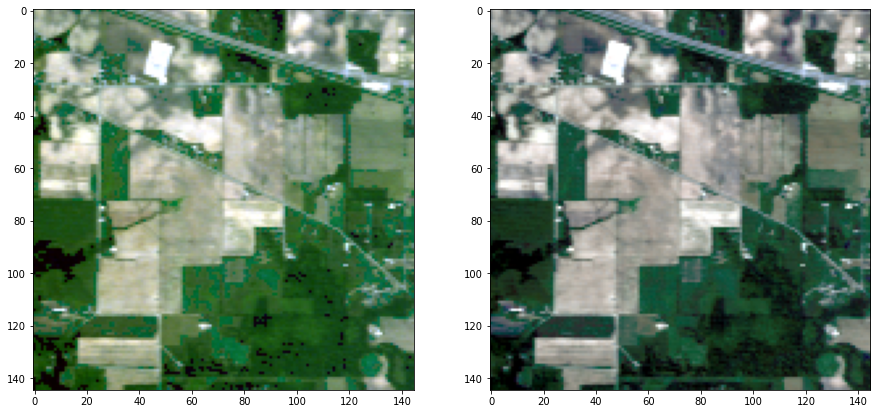

In [76]:
show_info_pca(arr_indiana)